In [2]:
import pyodbc
import sqlalchemy
import dotenv
import os

from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import axline
import seaborn as sns

from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import SGDRegressor, LinearRegression, RANSACRegressor, ElasticNetCV, TheilSenRegressor, PassiveAggressiveRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, StackingRegressor, ExtraTreesRegressor

from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
import keras
from scikeras.wrappers import KerasRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import BaseCrossValidator

dotenv.load_dotenv()

sql_server = os.getenv('SQL_SERVER')
db_conn_string = f'DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={sql_server};DATABASE=japan;Trusted_Connection=yes;'
connection_url = sqlalchemy.engine.URL.create(
    "mssql+pyodbc", 
    query={"odbc_connect": db_conn_string}
)
engine = sqlalchemy.create_engine(connection_url)
df_japan = pd.read_sql('SELECT * FROM Transactions', engine)
df_japan_copy = df_japan.copy()

print(df_japan.head())

columns_to_encode = ['RealEstateType', 'Region', 'Prefecture', 'City', 'District', 'FrontageRoadType', 'FrontageRoadDirection', 'LandShape', 'PlanningType']
# Floorplan, CurrentUsage, PostTransactionUsage, Structure, BuildingYear either drop or input with unknown
columns_to_drop = ['ID', 'NearestStation', 'TransactionQuarter', 'Price', 'UnitPrice', 'FloorArea']
tentative_columns = ['FloorPlan', 'CurrentUsage', 'PostTransactionUsage', 'Structure', 'BuildingYear']
numerical_values = ['MinTimeToNearestStation', 'MaxTimeToNearestStation', 'Area', 'GreatArea', 'GreatFloorArea', 'FrontageRoadBreadth', 'MaximumBuildingCoverageRatio', 'PrewarBuilding', 'TransactionYear']

price = df_japan['Price']

df_japan = df_japan.drop(columns=columns_to_drop)
# df_japan = df_japan.drop(columns=tentative_columns)
print(df_japan.info())
print(df_japan.drop(columns=columns_to_encode).info())

df_japan = pd.get_dummies(df_japan, columns=columns_to_encode)
df_japan = pd.get_dummies(df_japan, columns=tentative_columns)
print(df_japan.info())
print(df_japan.shape)

X_train, X_test, y_train, y_test = train_test_split(df_japan, price, test_size=0.2)

y_test = np.log(y_test)
y_train = np.log(y_train)

       ID  RealEstateType  Region  Prefecture  City  District  NearestStation  \
0  435310              56    46.0          20   373   38907.0          2807.0   
1  435311              56    46.0          20   373   38907.0          2807.0   
2  435312              56    46.0          20   373   38907.0          2807.0   
3  435313              56    46.0          20   373   38173.0          2810.0   
4  435314              56    46.0          20   373   38173.0          2793.0   

   MinTimeToNearestStation  MaxTimeToNearestStation       Price  ...  \
0                     21.0                     21.0   4000000.0  ...   
1                     26.0                     26.0  21000000.0  ...   
2                     26.0                     26.0  10000000.0  ...   
3                     13.0                     13.0  12000000.0  ...   
4                      9.0                      9.0  37000000.0  ...   

   LandShape  BuildingYear  PrewarBuilding  Structure  CurrentUsage  \
0      11

In [2]:
def build_dnn(meta): 
    model= keras.models.Sequential([
                    keras.layers.Dense(200,activation='leaky_relu', input_dim=meta["n_features_in_"]),
                    keras.layers.LayerNormalization(),
                    keras.layers.Dense(400,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(600,activation='leaky_relu'),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dense(400,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(200,activation='leaky_relu'),
                    keras.layers.Dense(100,activation='leaky_relu'),
                    keras.layers.Dropout(0.2),
                    keras.layers.Dense(50,activation='leaky_relu'),
                    keras.layers.Dense(1, activation='linear')
        ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])
    return model

TweedieRegressor(max_iter=6000, power=1)
score:  0.5576874060294319
R-square (R2): 0.5699087272191853
D-square (D2): 0.5576874060294241
Median absolute error: 0.5846824231132111
Root mean squared error: 1.1054353882600554
(array([], dtype=int64),)


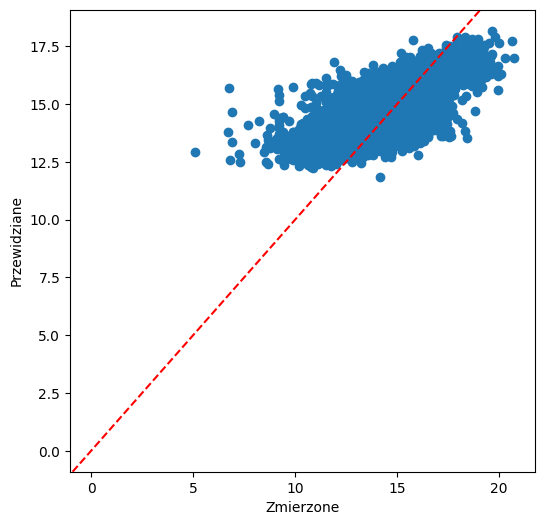

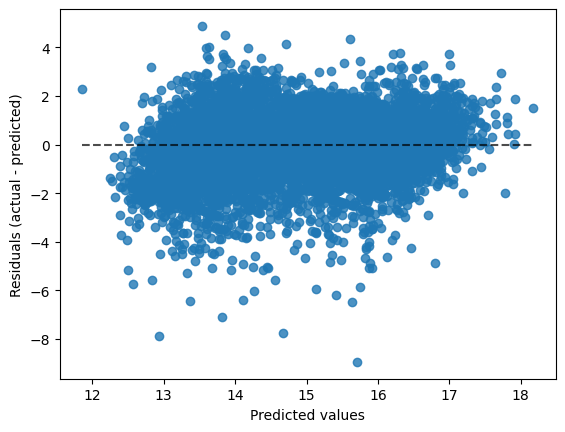

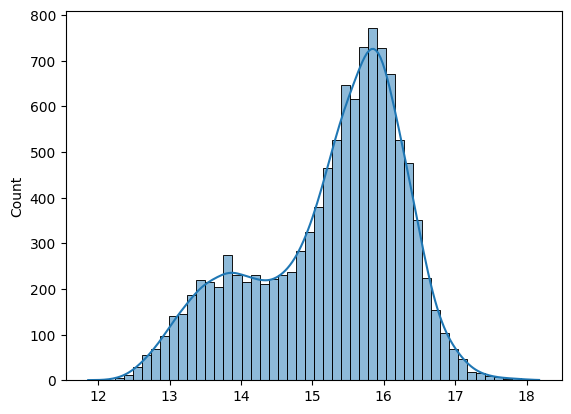

Transformed from log, back to price

R-square (R2): 0.12467303787463402
D-square (D2): 0.32175491392029476
Median absolute error: 2255487.816174207
Root mean squared error: 25036633.34103446
(array([], dtype=int64),)


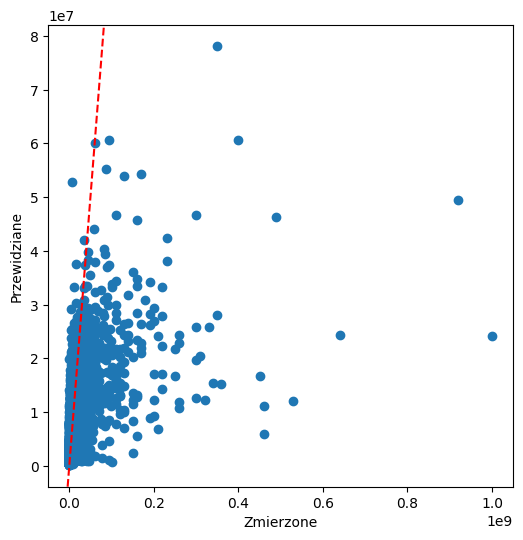

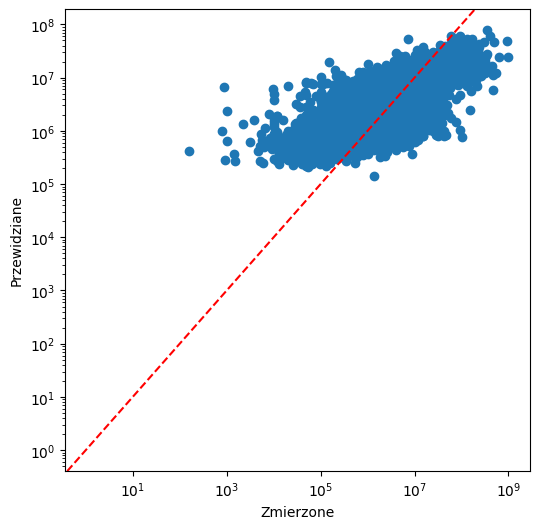

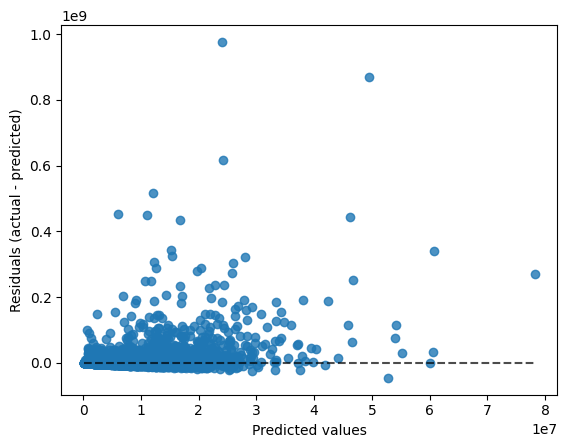

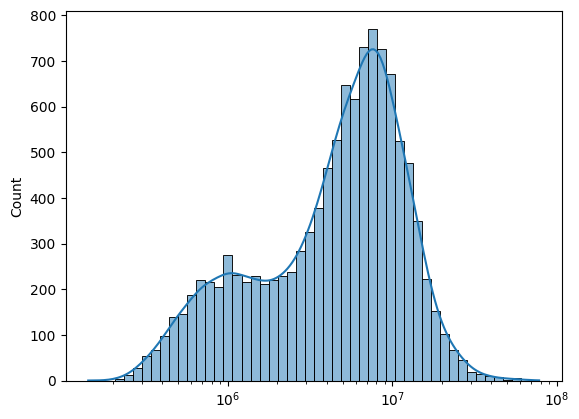

HistGradientBoostingRegressor(random_state=29)
score:  0.7287612366676647
R-square (R2): 0.7287612366676647
D-square (D2): 0.7164146407672627
Median absolute error: 0.3887051619334878
Root mean squared error: 0.8778674094148775
(array([], dtype=int64),)


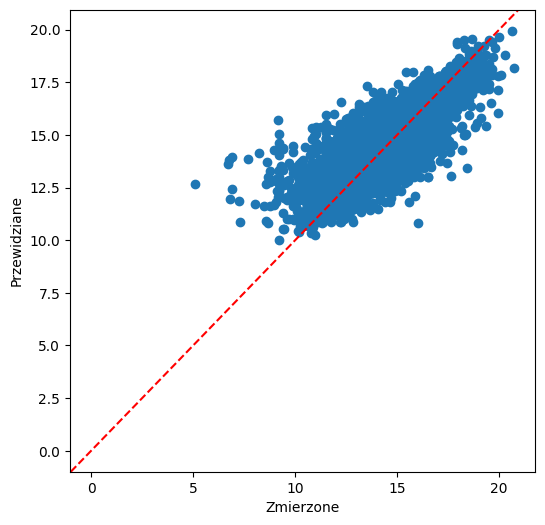

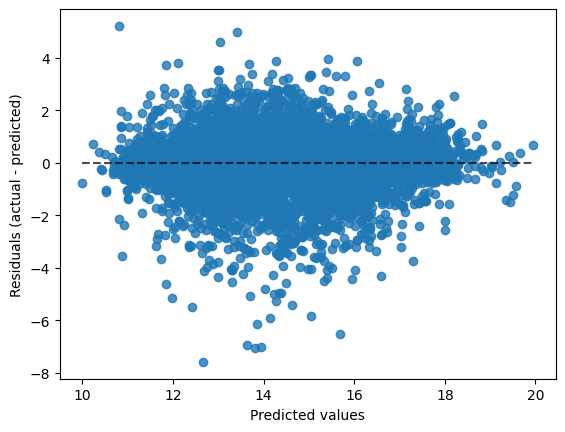

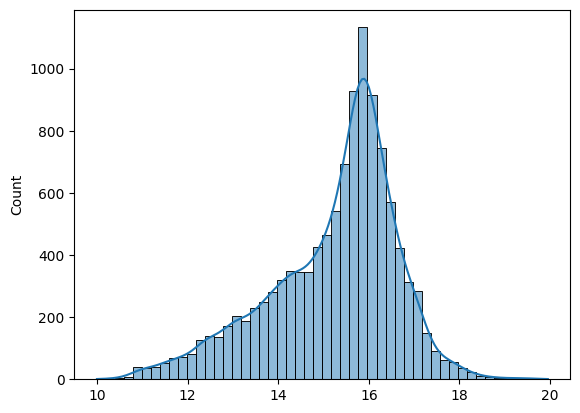

Transformed from log, back to price

R-square (R2): 0.4482711507984001
D-square (D2): 0.6670913110570265
Median absolute error: 1682593.305341871
Root mean squared error: 19877127.47072823
(array([], dtype=int64),)


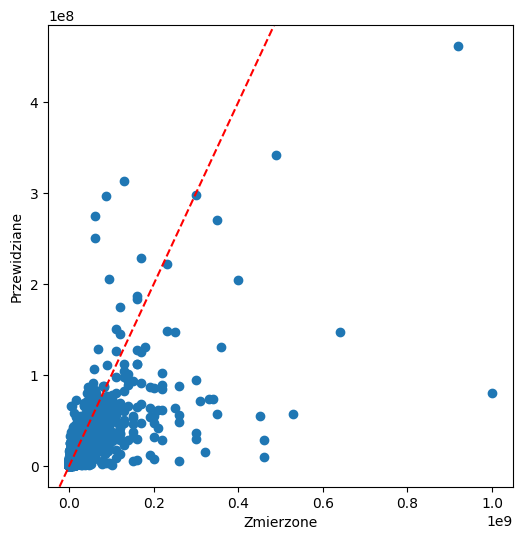

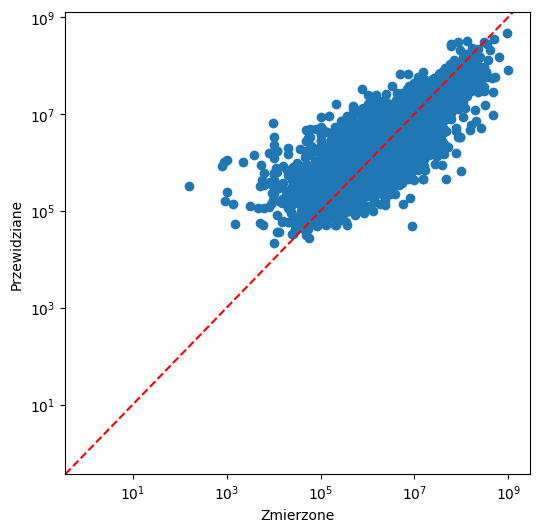

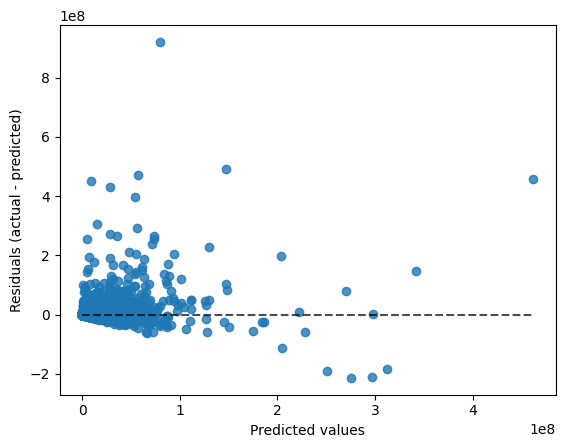

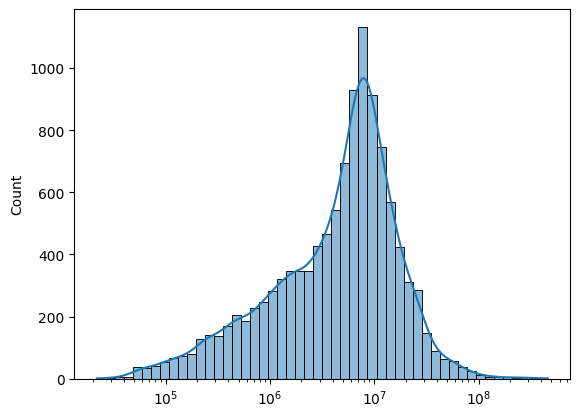

In [ ]:
from sklearn.metrics import PredictionErrorDisplay, r2_score, median_absolute_error, root_mean_squared_error, d2_tweedie_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.linear_model import TweedieRegressor, BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

inputer = ColumnTransformer([
    ("categorical", "passthrough", df_japan.select_dtypes(include='bool').columns),
    ("numerical_input", KNNImputer(missing_values=np.nan), df_japan.select_dtypes(include=['float64', 'int64']).columns),
], remainder='passthrough', verbose_feature_names_out=False)
inputer.set_output(transform='pandas')

q_transformer = ColumnTransformer([
    ("categorical", "passthrough", df_japan.select_dtypes(include='bool').columns),
    ("q_transformer", QuantileTransformer(output_distribution='normal', random_state=29),  df_japan.select_dtypes(include=['float64', 'int64']).columns)
], remainder='passthrough', verbose_feature_names_out=False)
q_transformer.set_output(transform='pandas')

scaler = ColumnTransformer([
    ("categorical", "passthrough", df_japan.select_dtypes(include='bool').columns),
    ("scaler", StandardScaler(), df_japan.select_dtypes(include=['float64', 'int64']).columns)
], remainder='passthrough', verbose_feature_names_out=False)
scaler.set_output(transform='pandas')

models = [
    Pipeline([
        # ('transformer_in', ColumnTransformer([
        #     ("categorical", "passthrough", df_japan.select_dtypes(include='bool').columns),
        #     ("numerical_input", KNNImputer(missing_values=np.nan), df_japan.select_dtypes(include=['float64', 'int64']).columns),
        # ], remainder='passthrough', verbose_feature_names_out=False)),
        # ("q_transformer", QuantileTransformer(output_distribution='normal', random_state=29)),
        # ('scaler', StandardScaler()),
        ('inputer', inputer),
        ("q_transformer", q_transformer),
        ('scaler', scaler),
        ('model', TweedieRegressor(power=1, max_iter=6000))
    ]),
    Pipeline([
        ('model', HistGradientBoostingRegressor(random_state=29))
    ]),
]

for model in models:
    print(model[-1])
    hist = model.fit(X_train, y_train)
    print("score: ", hist.score(X_test, y_test))
    predicted = model.predict(X_test)
    actual = y_test

    r2 = r2_score(actual, predicted)
    mae = median_absolute_error(actual, predicted)
    rmse = root_mean_squared_error(actual, predicted)
    d2 = d2_tweedie_score(actual, predicted, power=1)
    print(f"R-square (R2): {r2}")
    print(f"D-square (D2): {d2}")
    print(f"Median absolute error: {mae}")
    print(f"Root mean squared error: {rmse}")
    print(np.where(predicted < 0))

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Zmierzone")
    ax.set_ylabel("Przewidziane")

    display = PredictionErrorDisplay(y_true=actual, y_pred=predicted)
    display.plot()
    plt.show()

    sns.histplot(predicted, kde=True, bins=50)
    plt.show()

    print("Transformed from log, back to price\n")

    exp_predicted = np.exp(predicted)
    exp_actual = np.exp(actual)
    r2 = r2_score(exp_actual, exp_predicted)
    mae = median_absolute_error(exp_actual, exp_predicted)
    rmse = root_mean_squared_error(exp_actual, exp_predicted)
    d2 = d2_tweedie_score(exp_actual, exp_predicted, power=1)
    print(f"R-square (R2): {r2}")
    print(f"D-square (D2): {d2}")
    print(f"Median absolute error: {mae}")
    print(f"Root mean squared error: {rmse}")
    print(np.where(exp_predicted < 0))

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(exp_actual, exp_predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Zmierzone")
    ax.set_ylabel("Przewidziane")
    plt.show()

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(exp_actual, exp_predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Zmierzone")
    ax.set_ylabel("Przewidziane")
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.show()

    display = PredictionErrorDisplay(y_true=exp_actual, y_pred=exp_predicted)
    display.plot()
    plt.show()

    sns.histplot(exp_predicted, kde=True, log_scale=True, bins=50)
    plt.show()

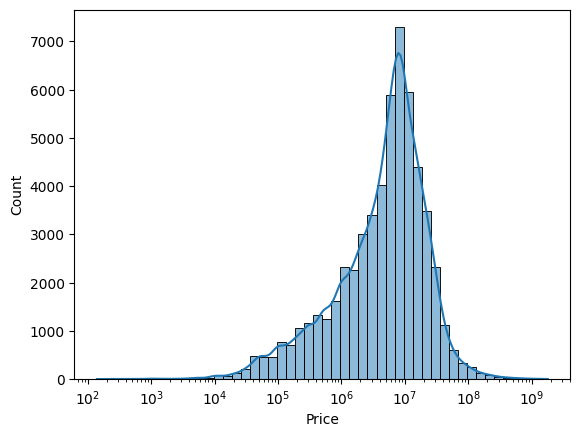

In [4]:
sns.histplot(price, kde=True, log_scale=True, bins=50)
plt.show()

In [5]:
df_japan_copy_2 = df_japan_copy.copy()

df_japan_cheap = df_japan_copy_2[df_japan_copy_2['Price'] < 50000000]
df_japan_expensive = df_japan_copy_2[df_japan_copy_2['Price'] >= 50000000]
prices_cheap = df_japan_cheap['Price']
prices_expensive = df_japan_expensive['Price']

df_japan_cheap = df_japan_cheap.drop(columns=columns_to_drop)
df_japan_cheap = pd.get_dummies(df_japan_cheap, columns=columns_to_encode)
df_japan_cheap = pd.get_dummies(df_japan_cheap, columns=tentative_columns)
X_train_cheap, X_test_cheap, y_train_cheap, y_test_cheap = train_test_split(df_japan_cheap, prices_cheap, test_size=0.2)
y_train_cheap = np.log(y_train_cheap)
y_test_cheap = np.log(y_test_cheap)

df_japan_expensive = df_japan_expensive.drop(columns=columns_to_drop)
df_japan_expensive = pd.get_dummies(df_japan_expensive, columns=columns_to_encode)
df_japan_expensive = pd.get_dummies(df_japan_expensive, columns=tentative_columns)
X_train_expensive, X_test_expensive, y_train_expensive, y_test_expensive = train_test_split(df_japan_expensive, prices_expensive, test_size=0.2)
y_train_expensive = np.log(y_train_expensive)
y_test_expensive = np.log(y_test_expensive)

TweedieRegressor(max_iter=6000, power=1)
score:  0.7174172769198495
R-square (R2): 0.7272632651713224
D-square (D2): 0.7174172769198676
Median absolute error: 0.39168657815295127
Root mean squared error: 0.8471036006618341
(array([], dtype=int64),)


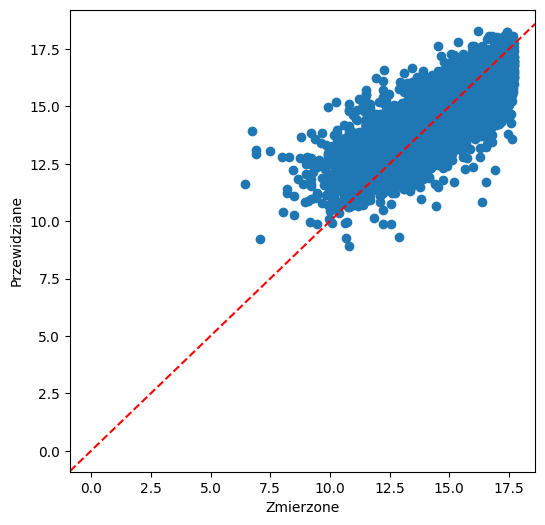

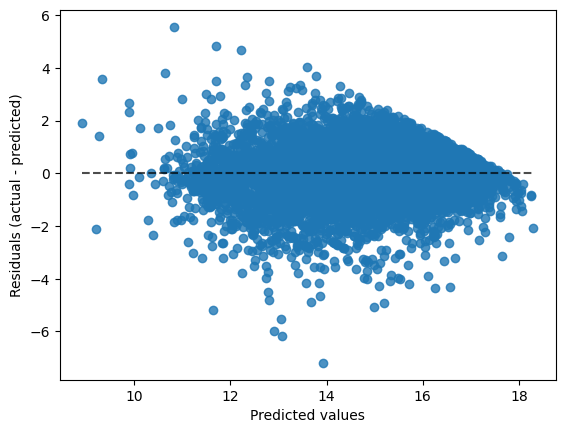

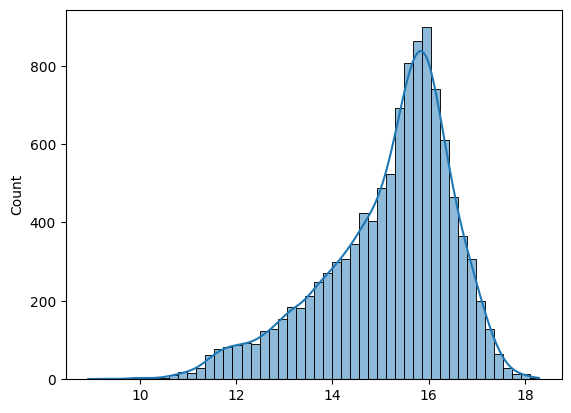

R-square (R2): 0.5045997372722154
D-square (D2): 0.5849886522009977
Median absolute error: 1594628.933497103
Root mean squared error: 6405448.570888403
(array([], dtype=int64),)


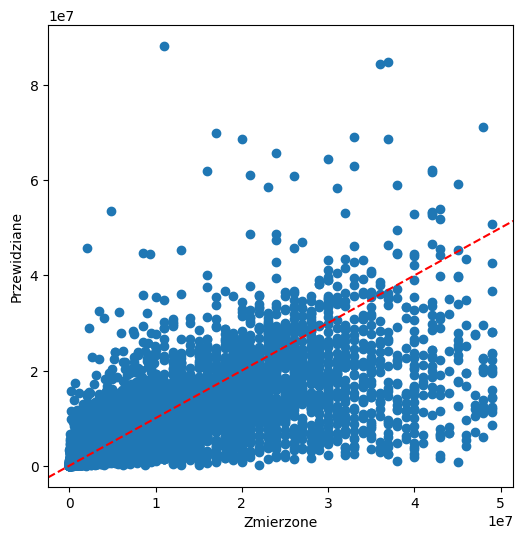

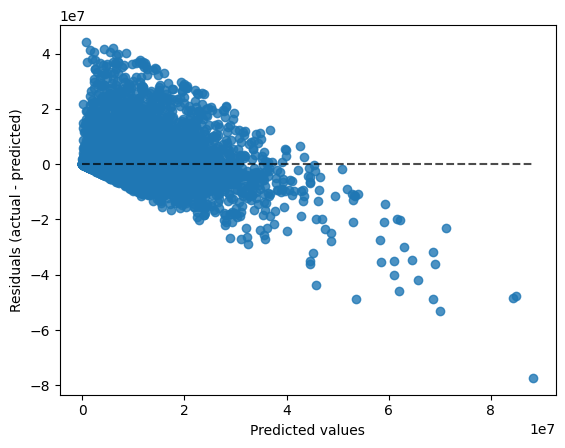

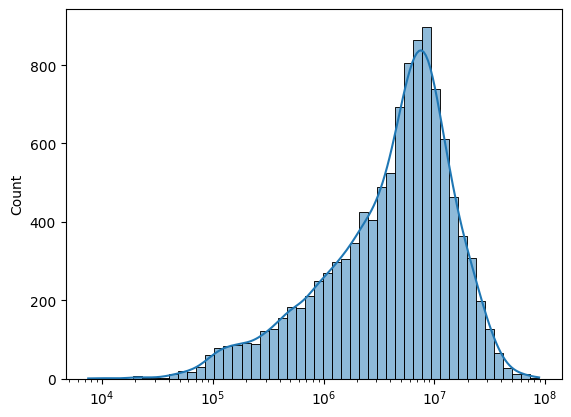

HistGradientBoostingRegressor(random_state=29)
score:  0.7331081986178871
R-square (R2): 0.7331081986178871
D-square (D2): 0.7214280640195039
Median absolute error: 0.3836816471415876
Root mean squared error: 0.8379774381677592
(array([], dtype=int64),)


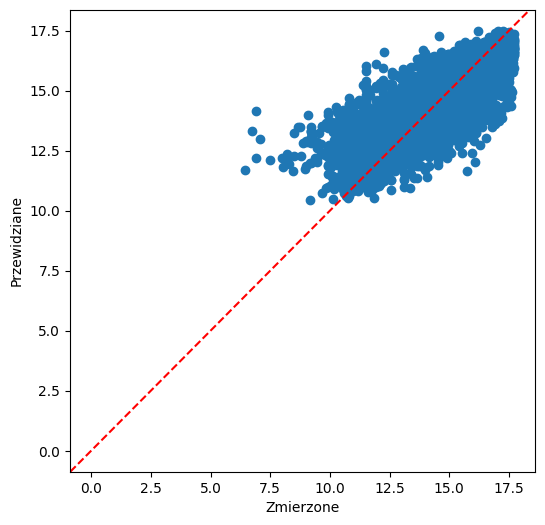

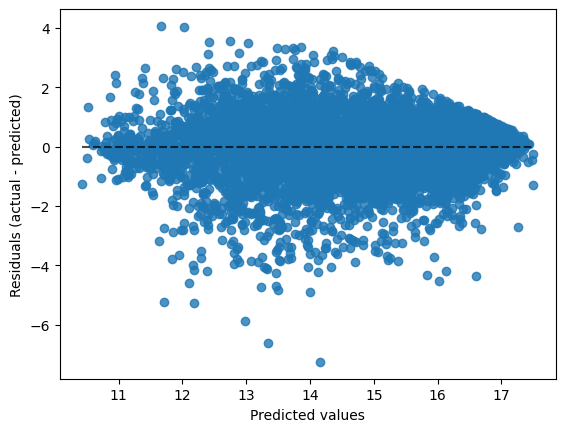

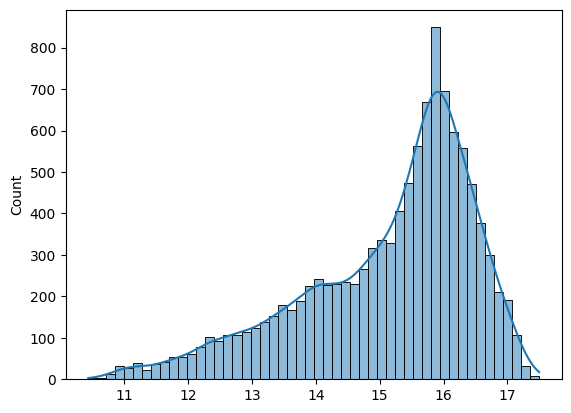

R-square (R2): 0.5805834470817512
D-square (D2): 0.6334806041536523
Median absolute error: 1588841.2822406804
Root mean squared error: 5893784.002201495
(array([], dtype=int64),)


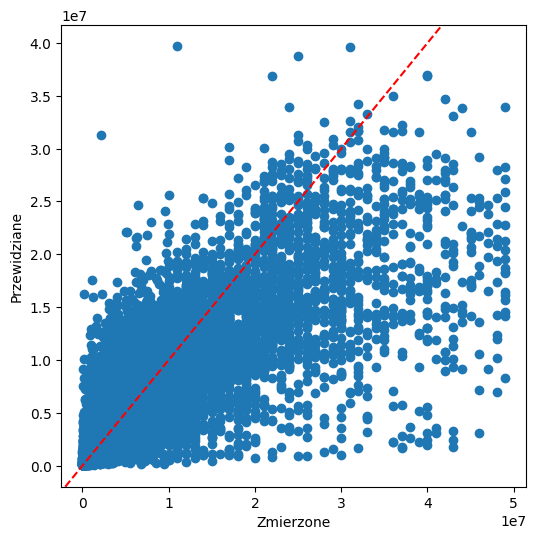

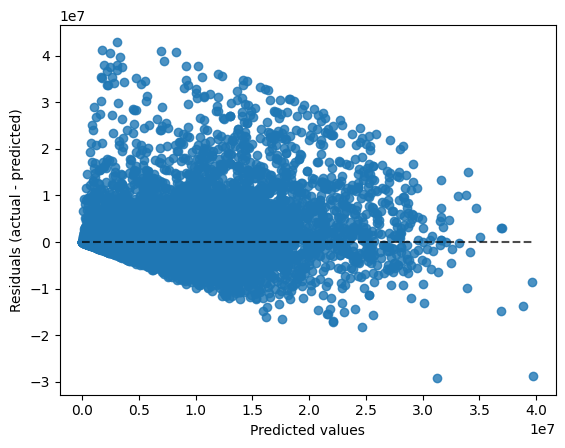

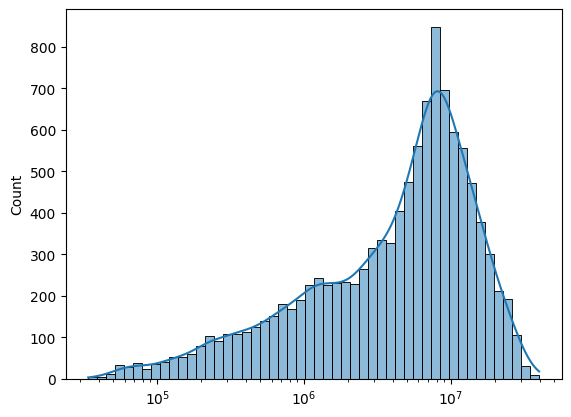

In [6]:
models = [Pipeline([
        # ('transformer_in', ColumnTransformer([
        #     #("categorical", "passthrough", df_japan_cheap.select_dtypes(include='bool').columns),
        #     ("numerical_input", KNNImputer(missing_values=np.nan), df_japan_cheap.select_dtypes(include=['float64', 'int64']).columns),
        # ], remainder='passthrough', verbose_feature_names_out=False)),
        # ("q_transformer", QuantileTransformer(output_distribution='normal', random_state=29)),
        # ('scaler', StandardScaler()),
        ('inputer', inputer),
        ("q_transformer", q_transformer),
        ('scaler', scaler),
        ('model', TweedieRegressor(power=1, max_iter=6000))
    ]),
    Pipeline([
        ('model', HistGradientBoostingRegressor(random_state=29))
    ])
]

for model in models:
    print(model[-1])
    hist = model.fit(X_train_cheap, y_train_cheap)
    print("score: ", hist.score(X_test_cheap, y_test_cheap))
    predicted = model.predict(X_test_cheap)
    actual = y_test_cheap

    r2 = r2_score(actual, predicted)
    mae = median_absolute_error(actual, predicted)
    rmse = root_mean_squared_error(actual, predicted)
    d2 = d2_tweedie_score(actual, predicted, power=1)
    print(f"R-square (R2): {r2}")
    print(f"D-square (D2): {d2}")
    print(f"Median absolute error: {mae}")
    print(f"Root mean squared error: {rmse}")
    print(np.where(predicted < 0))

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Zmierzone")
    ax.set_ylabel("Przewidziane")

    display = PredictionErrorDisplay(y_true=actual, y_pred=predicted)
    display.plot()
    plt.show()

    sns.histplot(predicted, kde=True, bins=50)
    plt.show()

    exp_predicted = np.exp(predicted)
    exp_actual = np.exp(actual)
    r2 = r2_score(exp_actual, exp_predicted)
    mae = median_absolute_error(exp_actual, exp_predicted)
    rmse = root_mean_squared_error(exp_actual, exp_predicted)
    d2 = d2_tweedie_score(exp_actual, exp_predicted, power=1)
    print(f"R-square (R2): {r2}")
    print(f"D-square (D2): {d2}")
    print(f"Median absolute error: {mae}")
    print(f"Root mean squared error: {rmse}")
    print(np.where(exp_predicted < 0))

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(exp_actual, exp_predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Zmierzone")
    ax.set_ylabel("Przewidziane")

    display = PredictionErrorDisplay(y_true=exp_actual, y_pred=exp_predicted)
    display.plot()
    plt.show()

    sns.histplot(exp_predicted, kde=True, log_scale=True, bins=50)
    plt.show()

TweedieRegressor(max_iter=6000, power=1)
score:  0.024570323237723457
R-square (R2): 0.02153308243536667
D-square (D2): 0.024570323237009473
Median absolute error: 0.3397476193758564
Root mean squared error: 0.5749947804344853
(array([], dtype=int64),)


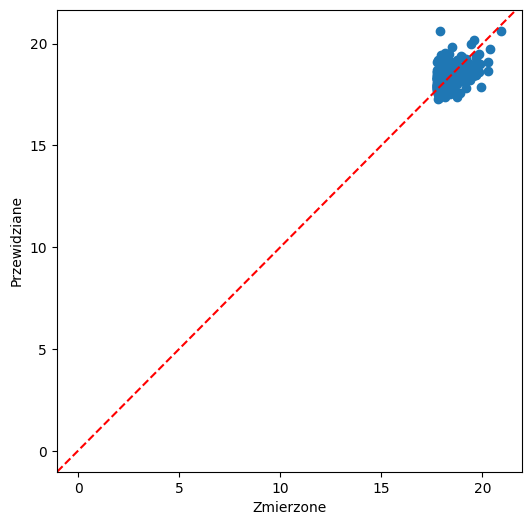

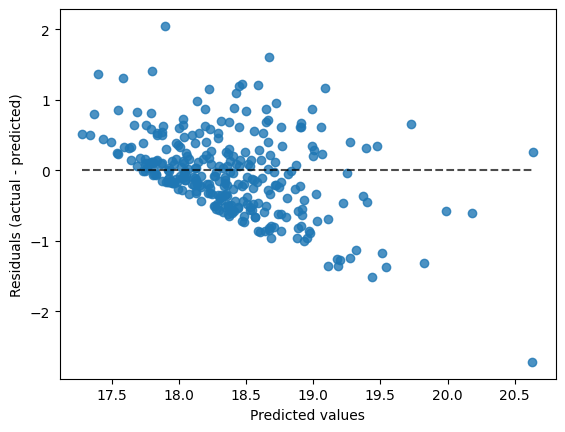

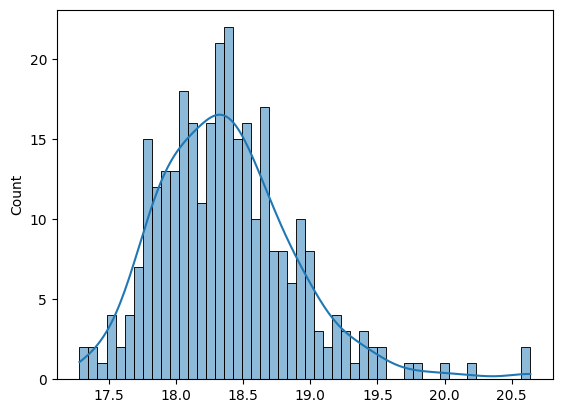

R-square (R2): 0.17811516390940196
D-square (D2): 0.2432481412228189
Median absolute error: 29035592.69120138
Root mean squared error: 102010673.1704144
(array([], dtype=int64),)


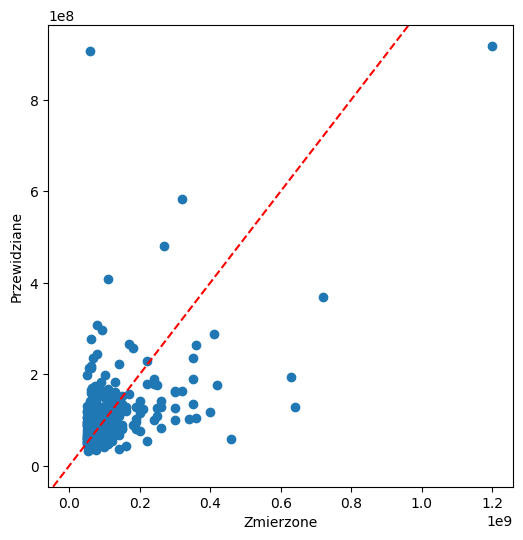

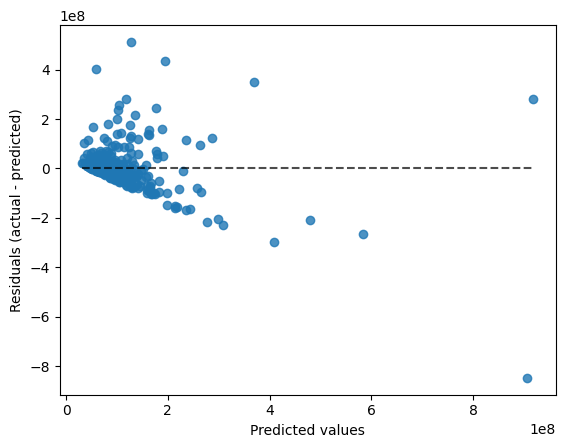

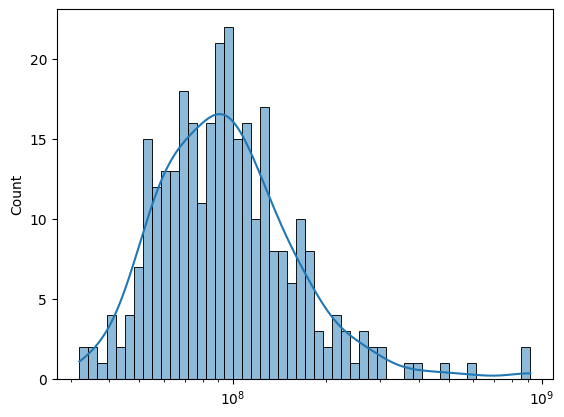

HistGradientBoostingRegressor(random_state=29)
score:  0.17212032371808317
R-square (R2): 0.17212032371808317
D-square (D2): 0.17219202349875395
Median absolute error: 0.2925398724703996
Root mean squared error: 0.52890106276079
(array([], dtype=int64),)


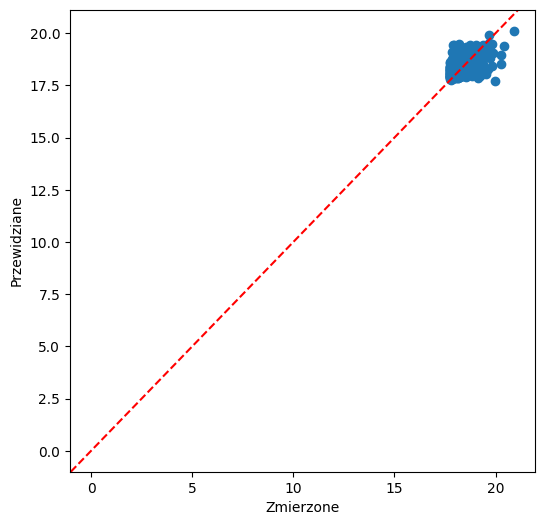

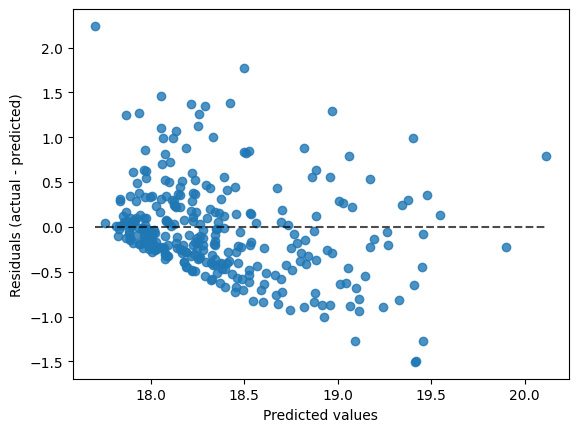

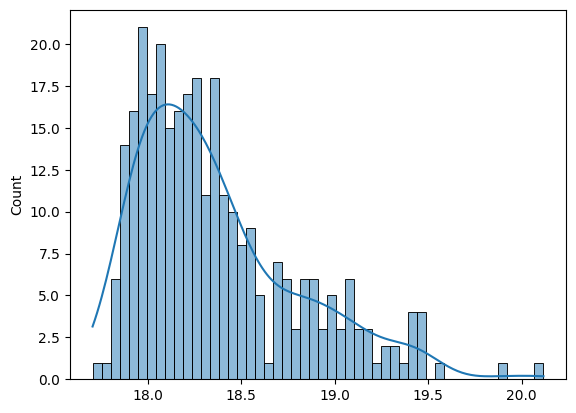

R-square (R2): 0.31023262318043676
D-square (D2): 0.29649030205897753
Median absolute error: 25414286.901696756
Root mean squared error: 93452614.21672943
(array([], dtype=int64),)


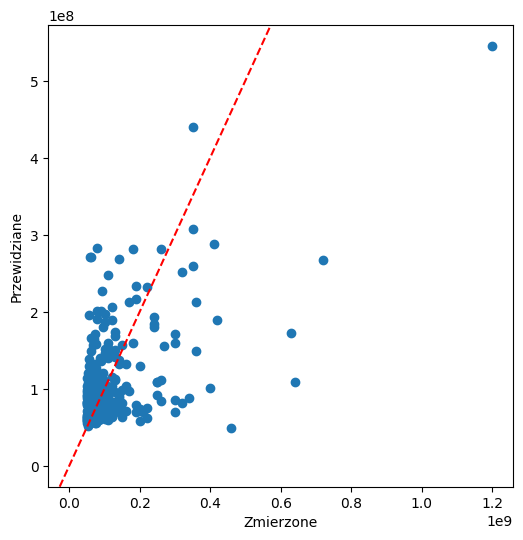

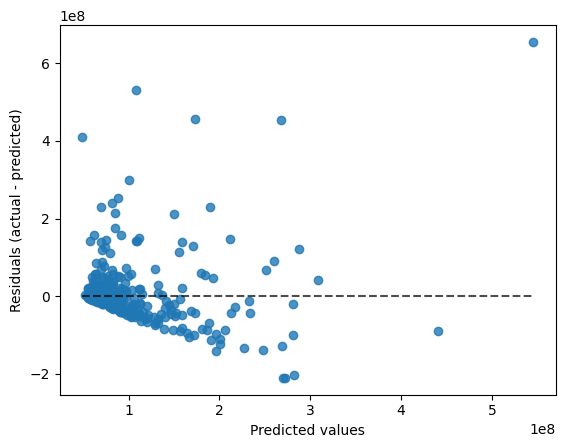

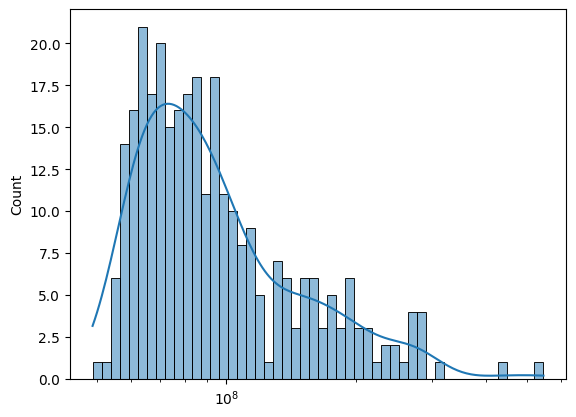

In [7]:
models = [Pipeline([
        # ('transformer_in', ColumnTransformer([
        #     #("categorical", "passthrough", df_japan_expensive.select_dtypes(include='bool').columns),
        #     ("numerical_input", KNNImputer(missing_values=np.nan), df_japan_expensive.select_dtypes(include=['float64', 'int64']).columns),
        # ], remainder='passthrough', verbose_feature_names_out=False)),
        # ("q_transformer", QuantileTransformer(output_distribution='normal', random_state=29)),
        # ('scaler', StandardScaler()),
        ('inputer', inputer),
        ("q_transformer", q_transformer),
        ('scaler', scaler),
        ('model', TweedieRegressor(power=1, max_iter=6000))
    ]),
    Pipeline([
        ('model', HistGradientBoostingRegressor(random_state=29))
    ])
]

for model in models:
    print(model[-1])
    hist = model.fit(X_train_expensive, y_train_expensive)
    print("score: ", hist.score(X_test_expensive, y_test_expensive))
    predicted = model.predict(X_test_expensive)
    actual = y_test_expensive

    r2 = r2_score(actual, predicted)
    mae = median_absolute_error(actual, predicted)
    rmse = root_mean_squared_error(actual, predicted)
    d2 = d2_tweedie_score(actual, predicted, power=1)
    print(f"R-square (R2): {r2}")
    print(f"D-square (D2): {d2}")
    print(f"Median absolute error: {mae}")
    print(f"Root mean squared error: {rmse}")
    print(np.where(predicted < 0))

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(actual, predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Zmierzone")
    ax.set_ylabel("Przewidziane")

    display = PredictionErrorDisplay(y_true=actual, y_pred=predicted)
    display.plot()
    plt.show()

    sns.histplot(predicted, kde=True, bins=50)
    plt.show()

    exp_predicted = np.exp(predicted)
    exp_actual = np.exp(actual)
    r2 = r2_score(exp_actual, exp_predicted)
    mae = median_absolute_error(exp_actual, exp_predicted)
    rmse = root_mean_squared_error(exp_actual, exp_predicted)
    d2 = d2_tweedie_score(exp_actual, exp_predicted, power=1)
    print(f"R-square (R2): {r2}")
    print(f"D-square (D2): {d2}")
    print(f"Median absolute error: {mae}")
    print(f"Root mean squared error: {rmse}")
    print(np.where(exp_predicted < 0))

    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(exp_actual, exp_predicted)
    axline((0, 0), (1, 1), color='r', linestyle='--')
    ax.set_xlabel("Zmierzone")
    ax.set_ylabel("Przewidziane")

    display = PredictionErrorDisplay(y_true=exp_actual, y_pred=exp_predicted)
    display.plot()
    plt.show()

    sns.histplot(exp_predicted, kde=True, log_scale=True, bins=50)
    plt.show()